In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-07-24 11:23:17--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.136.200, 52.217.140.136, 52.217.204.184, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.136.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.0MB/s    in 0.7s    

2023-07-24 11:23:18 (19.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np

temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1] # 2번째 열을 temperature 배열에 저장
  raw_data[i, :] = values[:] # 모든 열을 raw_data 배열에 저장

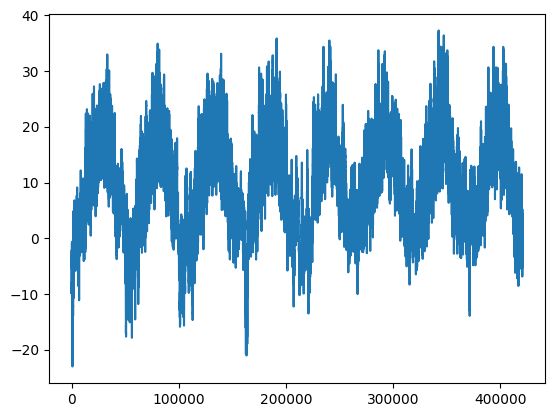

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)), temperature)
plt.show()

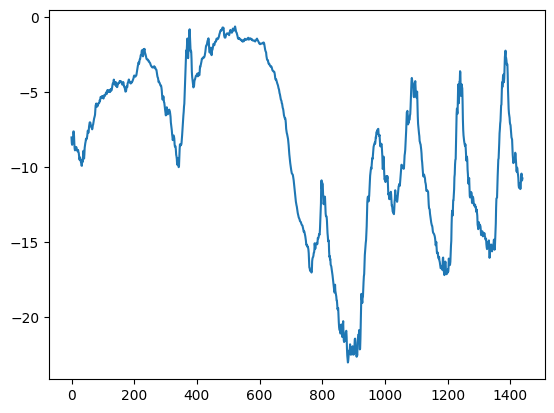

In [5]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [7]:
# 50%, 25%, 25% 분리(검증, 테스트는 훈련보다 미래여야 함!!)
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [8]:
# 데이터 정규화
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

In [11]:
from tensorflow import keras

int_sequence = (np.arange(10))
dummy_dataset = keras.utils.timeseries_dataset_from_array(
														  data = int_sequence[:-3],
														  targets = int_sequence[3:],
														  sequence_length = 3,
														  batch_size = 2
)

for inputs, targets in dummy_dataset:
	for i in range(inputs.shape[0]):
		print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [12]:
sampling_rate =  6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples
)


In [14]:
for samples, targets in train_dataset:
  print("샘플 크기 : ", samples.shape)
  print("타깃 크기 : ", targets.shape)
  break

샘플 크기 :  (256, 120, 14)
타깃 크기 :  (256,)


In [15]:
# 상식 수준의 평가
def evaluate_naive_method(dataset):
  total_abs_err = 0
  samples_seen = 0
  for samples, targets in dataset:

    # 특성이 이미 정규화되었음 -> 온도를 섭씨로 바꾸는 과정
    preds = samples[:, -1, 1] * std[1] + mean[1] # 온도 특성은 칼럼 인덱스 1에 있다.

    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen


print(f"검증 MAE : {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE : {evaluate_naive_method(test_dataset):.2f}")


검증 MAE : 2.44
테스트 MAE : 2.62


In [21]:
# 머신러닝 모델로 시도하기
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape =  (sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = 'relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only = True)
]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset, callbacks = callbacks)
model = keras.models.load_model('jena_dense.keras')
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]}:.2f")

Epoch 1/10
819/819 [==============================] - 52s 63ms/step - loss: 12.5208 - mae: 2.7461 - val_loss: 11.7487 - val_mae: 2.7111
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 9.0690 - mae: 2.3719 - val_loss: 12.6759 - val_mae: 2.8359
Epoch 3/10
819/819 [==============================] - 60s 72ms/step - loss: 8.3161 - mae: 2.2693 - val_loss: 10.0639 - val_mae: 2.5068
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 7.8018 - mae: 2.1994 - val_loss: 11.7891 - val_mae: 2.7140
Epoch 5/10
819/819 [==============================] - 45s 54ms/step - loss: 7.4900 - mae: 2.1551 - val_loss: 10.4634 - val_mae: 2.5582
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 7.2537 - mae: 2.1232 - val_loss: 10.4045 - val_mae: 2.5486
Epoch 7/10
819/819 [==============================] - 45s 54ms/step - loss: 7.0426 - mae: 2.0916 - val_loss: 11.0417 - val_mae: 2.6081
Epoch 8/10
819/819 [==============================] - 

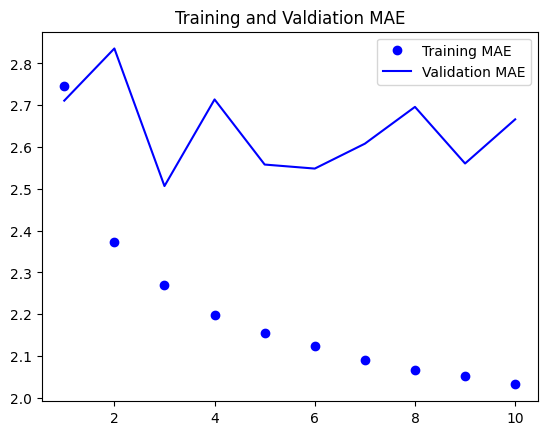

In [24]:
# 시각화
import matplotlib.pyplot as plt

def visualize(history):
  loss = history.history['mae']
  val_loss = history.history['val_mae']
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label = "Training MAE")
  plt.plot(epochs, val_loss, 'b-', label = "Validation MAE")
  plt.title("Training and Valdiation MAE")
  plt.legend()
  plt.show()

visualize(history)

In [ ]:
# 1D 합성곱 시도하기
inputs = keras.Input(shape =  (sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation = 'relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation = 'relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation = 'relu')(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jean_conv.keras", save_best_only = True)
]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset, callbacks = callbacks)

model = keras.models.load_model('jean_conv.keras')
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 42s 50ms/step - loss: 31.9863 - mae: 4.4089 - val_loss: 21.6271 - val_mae: 3.6725
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 22.4691 - mae: 3.7910 - val_loss: 20.7869 - val_mae: 3.6039
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 21.8411 - mae: 3.7365 - val_loss: 20.5020 - val_mae: 3.5853
Epoch 4/10
819/819 [==============================] - 49s 59ms/step - loss: 21.4683 - mae: 3.7034 - val_loss: 20.2356 - val_mae: 3.5685
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 21.2428 - mae: 3.6834 - val_loss: 20.0466 - val_mae: 3.5402
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 21.0677 - mae: 3.6682 - val_loss: 19.7430 - val_mae: 3.5304
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 20.9181 - mae: 3.6555 - val_loss: 19.3958 - val_mae: 3.4872
Epoch 8/10
819/819 [============================

In [ ]:
visualize(history)

In [ ]:
# 순환 신경망 써보기
inputs = keras.Input(shape =  (sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only = True)
]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset, callbacks = callbacks)
model = keras.models.load_model('jena_lstm.keras')
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
visualize(history)

In [ ]:
# 간단한 RNN 정방향 계산 구현하기

# state_t = 0 # 타임스텝 t의 상태
# for input_t in input_sequence:
#   output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
#   state_t = output_t

In [ ]:
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features)) # 랜덤 잡음
state_t = np.zeros((output_features,  )) # 초기 상태 : 0벡터

# 랜덤 가중치 행렬
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs: # inputs.shape : (input_features,)
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) # 1.
  successive_outputs.append(output_t)
  state_t = output_t # 2.

final_output_sequence = np.stack(successive_outputs, axis = 0)

In [ ]:
# 순환 드롭아웃
inputs = keras.Input(shape = (sequence_length, ), raw_data.shape[-1])
x = layers.LSTM(32, recurrent_dropout = 0.25)(inputs)
x = layers.Dropout(0.5)(x) # dense 층에 규제를 추가함
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
			 keras.callbacks.Modelcheckpoint('jena_lstm_dropout.keras',
			 save_best_only = True)
]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset,
				   epochs = 50,
				   validation_data = val_dataset,
				   callbacks = callbacks)

In [ ]:
# 순환층 스태킹
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))

# 그냥 순환층을 쌓는데, 마지막 순환층을 제외하고 모두 return_sequences = True임.
x = layers.GRU(32, recurrent_dropout = 0.5, return_sequences = True)(inputs)
x = layers.GRU(32, recurrent_dropout = 0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
			 keras.callbacks.Modelcheckpoint('jena_lstm_dropout.keras',
			 save_best_only = True)
]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset,
				   epochs = 50,
				   validation_data = val_dataset,
				   callbacks = callbacks)

In [ ]:
# 양방향 RNN
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(train_dataset,
				   epochs = 10,
				   validation_data = val_dataset,
)